In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from time import time
import os

from utils import reset_seed, display_compare

tf.config.experimental.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from sklearn.model_selection import train_test_split
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train_full = np.float32(x_train_full/255.)
x_test       = np.float32(x_test/255.)

# Define a simple GAN

In [3]:
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
from tensorflow.keras.models import Sequential
from tensorflow.nn import leaky_relu

def make_generator(latent_dim = 30):
    generator = Sequential([
        Input(shape=[latent_dim]),
        Dense(100, activation=leaky_relu),
        Dense(150, activation=leaky_relu),
        Dense(28 * 28, activation="sigmoid"),
        Reshape([28, 28])])
    return generator

def make_discriminator():
    discriminator = Sequential([
        Flatten(input_shape=[28, 28]),
        Dense(150, activation=leaky_relu),
        Dense(100, activation=leaky_relu),
        Dense(1, activation="sigmoid")])
    return discriminator

## Compile the models

In [4]:
def get_compiled_GAN(latent_dim = 30):
    generator     = make_generator(latent_dim)
    discriminator = make_discriminator()
    gan = Sequential([generator, discriminator])
    
    # Compile the discriminator first
    discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
    
    # Compile the whole GAN
    discriminator.trainable = False
    gan.compile(loss="binary_crossentropy", optimizer="rmsprop")
    return gan

## Training

In [16]:
def train_gan(gan, dataset, n_epochs=50, log_dir=None):
    generator, discriminator = gan.layers
    latent_dim = generator.input.shape[-1]
    
    # Create file writer
    if log_dir:
        log_dir = os.path.join(log_dir, datetime.now().strftime("%m%d_%H%M%S"))
        file_writer = tf.summary.create_file_writer(log_dir)
        # Sample 10 reference points from the latent space
        fixed_z = tf.random.normal(shape=[10, latent_dim])
    
    # Initialise Metrics
    mean_gen_loss = tf.keras.metrics.Mean()
    mean_dis_loss = tf.keras.metrics.Mean()
    
        
    for epoch in range(n_epochs):
        # Start Epoch
        print("Epoch {}/{}:".format(epoch+1, n_epochs), end="")
        start = time()
        
        for x_batch in dataset:
            
            # Prepare the discriminator inputs and labels 
            batch_size = x_batch.shape[0]
            z_noise    = tf.random.normal(shape=[batch_size, latent_dim])
            gen_images = generator(z_noise)
            x_disc     = tf.concat([gen_images, x_batch], axis=0)
            y_real     = tf.ones(batch_size)
            y_fake     = tf.zeros(batch_size)
            y_disc     = tf.concat([y_fake, y_real], axis=0)

            # 1. Training the discriminator
            discriminator.trainable = True
            dis_loss = discriminator.train_on_batch(x_disc, y_disc)
            mean_dis_loss.update_state(dis_loss)

            # 2. Training the generator
            discriminator.trainable = False
            z_noise  = tf.random.normal(shape=[batch_size, latent_dim])
            gen_loss = gan.train_on_batch(z_noise, y_real)
            mean_gen_loss.update_state(gen_loss)
        
        # Collect Epoch statitistics
        gen_loss = mean_gen_loss.result()
        dis_loss = mean_dis_loss.result()
        mean_gen_loss.reset_states()
        mean_dis_loss.reset_states()
        # Print statitistics
        print(" {:.1f}s".format(time()-start), end="")
        print("\tDiscriminator Loss: {:.3f}\tGenerator Loss: {:.3f}".format(dis_loss, gen_loss))
        
        # Update Summaries
        if log_dir:
            fixed_images = generator(fixed_z)
            if tf.size(tf.shape(fixed_images)) == 3:
                fixed_images = tf.expand_dims(fixed_images, -1)
            with file_writer.as_default():
                tf.summary.scalar("gen_loss", gen_loss, step=epoch)
                tf.summary.scalar("dis_loss", dis_loss, step=epoch)
                tf.summary.image("fixed_images", fixed_images, step=epoch, max_outputs=10)

In [8]:
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices(x_train_full).shuffle(1000)
train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)

In [11]:
latent_dim = 10
gan = get_compiled_GAN(latent_dim)
train_gan(gan, train_ds, n_epochs=1)

Epoch 1/1: 27.7s	Discriminator Loss: 0.491	Generator Loss: 1.546


# Generate new images

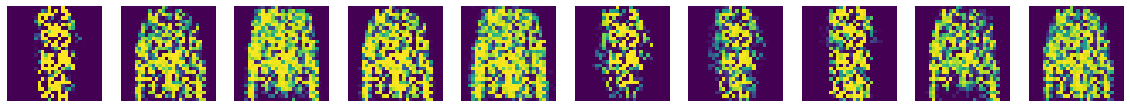

In [12]:
z_noise = tf.random.normal(shape=[10, latent_dim])
generator = gan.layers[0]
fake_images = generator(z_noise)
display_compare(fake_images)

## More training - Bigger latent space

In [17]:
latent_dim = 30
gan = get_compiled_GAN(latent_dim)
train_gan(gan, train_ds, n_epochs=20, log_dir="logs/GAN/")

Epoch 1/20: 28.2s	Discriminator Loss: 0.487	Generator Loss: 1.470
Epoch 2/20: 27.4s	Discriminator Loss: 0.496	Generator Loss: 1.403
Epoch 3/20: 27.6s	Discriminator Loss: 0.488	Generator Loss: 1.454
Epoch 4/20: 27.5s	Discriminator Loss: 0.504	Generator Loss: 1.391
Epoch 5/20: 27.3s	Discriminator Loss: 0.514	Generator Loss: 1.341
Epoch 6/20: 27.3s	Discriminator Loss: 0.507	Generator Loss: 1.345
Epoch 7/20: 27.4s	Discriminator Loss: 0.501	Generator Loss: 1.352
Epoch 8/20: 27.3s	Discriminator Loss: 0.501	Generator Loss: 1.366
Epoch 9/20: 27.4s	Discriminator Loss: 0.498	Generator Loss: 1.368
Epoch 10/20: 27.3s	Discriminator Loss: 0.497	Generator Loss: 1.363
Epoch 11/20: 27.1s	Discriminator Loss: 0.502	Generator Loss: 1.336
Epoch 12/20: 27.1s	Discriminator Loss: 0.504	Generator Loss: 1.326
Epoch 13/20: 27.1s	Discriminator Loss: 0.501	Generator Loss: 1.344
Epoch 14/20: 27.1s	Discriminator Loss: 0.492	Generator Loss: 1.394
Epoch 15/20: 27.0s	Discriminator Loss: 0.484	Generator Loss: 1.467
Epoc

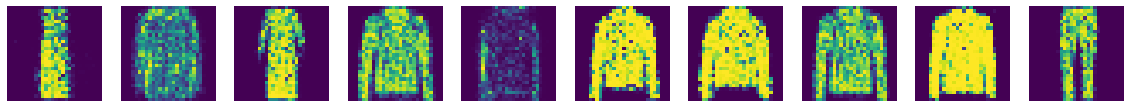

In [18]:
z_noise = tf.random.normal(shape=[10, 30])
generator = gan.layers[0]
fake_images = generator(z_noise)
display_compare(fake_images)